# Heart Disease Classification 

### Abstract
In the following project, a dataset with different features used for classifying heart disease is picked. A k-Nearest Neighbors model and a Random Forest classifier model is implemented below for predicting if a person has heart disease or not. Several methods for preprocessing the dataset for better results are used, such as undersampling the dataset, normalizing it etc.


## Imports

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from google.colab import files,drive
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from collections import Counter
from numpy import mean, std
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
import plotly.express as px
%matplotlib inline

## Mount google drive and load dataset

In [ ]:
files.upload() #Upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"stamatiskal","key":"2b4b059b607428bc27c45b2af9eeee2b"}'}

In [ ]:
# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease

  0% 0.00/3.13M [00:00<?, ?B/s]
100% 3.13M/3.13M [00:00<00:00, 209MB/s]


In [ ]:
! mkdir heart_disease
! unzip personal-key-indicators-of-heart-disease.zip  -d heart_disease
! rm personal-key-indicators-of-heart-disease.zip

Archive:  personal-key-indicators-of-heart-disease.zip
  inflating: heart_disease/heart_2020_cleaned.csv  


In [ ]:
data=pd.read_csv('/content/heart_disease/heart_2020_cleaned.csv')

## Exploratory Data Analysis

Checking the shape of the dataset and its 5 first samples.

In [ ]:
data.shape

(319795, 18)

In [ ]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
data.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

Checking if there are any NaN values for numerical and categorical and their info. 

In [ ]:
num_data=data.select_dtypes(exclude=['object'])

In [ ]:
num_data.isnull().sum()

BMI               0
PhysicalHealth    0
MentalHealth      0
SleepTime         0
dtype: int64

In [ ]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   BMI             319795 non-null  float64
 1   PhysicalHealth  319795 non-null  float64
 2   MentalHealth    319795 non-null  float64
 3   SleepTime       319795 non-null  float64
dtypes: float64(4)
memory usage: 9.8 MB


In [ ]:
obj_data=data.select_dtypes(include=['object'])

In [ ]:
obj_data.isnull().sum()

HeartDisease        0
Smoking             0
AlcoholDrinking     0
Stroke              0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
obj_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   HeartDisease      319795 non-null  object
 1   Smoking           319795 non-null  object
 2   AlcoholDrinking   319795 non-null  object
 3   Stroke            319795 non-null  object
 4   DiffWalking       319795 non-null  object
 5   Sex               319795 non-null  object
 6   AgeCategory       319795 non-null  object
 7   Race              319795 non-null  object
 8   Diabetic          319795 non-null  object
 9   PhysicalActivity  319795 non-null  object
 10  GenHealth         319795 non-null  object
 11  Asthma            319795 non-null  object
 12  KidneyDisease     319795 non-null  object
 13  SkinCancer        319795 non-null  object
dtypes: object(14)
memory usage: 34.2+ MB


The following function is used for finding every unique value in a feature.

In [ ]:
z = data[["Race"]]
def unique(z):
    x = np.array(z)
    print(np.unique(x))
unique(z)

['American Indian/Alaskan Native' 'Asian' 'Black' 'Hispanic' 'Other'
 'White']


## Data processing

Calculate the Yes/No Ratio for the HeartDisease feature.

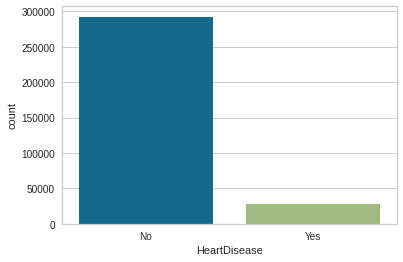

In [ ]:
sns.countplot(data = data, x = 'HeartDisease')

In [ ]:
k=0
l = 0
for i in range(0,len(data)):
  if data.HeartDisease[i] == 'No':
    k += 1 
  else:
    l += 1
#Find percentage between Heart Disease Yes and No 
split = [k/len(data), l/len(data)]
names =['Heart Disease: No', 'Heart Disease: Yes']

In [ ]:
fig = px.pie( data_frame = data, values= split, names= names, title='Heart Disease Percentage')
fig.show()

As shown above, the dataset is imbalanced. Because of it's size being big, the undersampling method is used, for the results will still be adequate.

In [ ]:
procdata = data # Making a copy of dataset for processing

In [ ]:
procdata.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

Splitting dataset to X and y for balancing it.

In [ ]:
X = procdata [['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer']]
y = procdata [['HeartDisease']]

I'm using sampling_strategy = 'majority' to undersample the majority of the outputs.

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy='majority')
x_res, y_res = under_sampler.fit_resample(X,y)
print("New shape of x is: ", x_res.shape, " and new shape of y is: ", y_res.shape)

New shape of x is:  (54746, 17)  and new shape of y is:  (54746, 1)


Concatenate the resampled data in one dataframe for further processing.

In [ ]:
procdata = pd.DataFrame()
procdata = pd.concat([y_res, x_res], axis = 1)

In [ ]:
procdata.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,19.69,Yes,No,No,0.0,0.0,No,Female,75-79,White,No,Yes,Very good,8.0,No,No,No
1,No,25.75,Yes,No,No,0.0,0.0,No,Female,70-74,White,No,No,Good,8.0,No,Yes,No
2,No,25.84,Yes,No,No,0.0,1.0,No,Female,60-64,White,No,Yes,Very good,7.0,No,No,No
3,No,30.11,No,No,No,0.0,0.0,No,Female,55-59,White,No,Yes,Excellent,7.0,No,No,No
4,No,21.02,Yes,No,No,3.0,2.0,Yes,Male,75-79,White,No,Yes,Fair,9.0,No,No,No


In [ ]:
procdata.shape

(54746, 18)

Making a plot to check if the new dataframe is now balanced.

In [ ]:
k=0
l = 0
for i in range(0,len(procdata)):
  if procdata.HeartDisease[i] == 'No':
    k += 1 
  else:
    l += 1
#Find percentage between Heart Disease Yes and No 
split = [k/len(procdata), l/len(procdata)]
names =['Heart Disease: No', 'Heart Disease: Yes']

In [ ]:
fig = px.pie( data_frame = procdata, values= split, names= names, title='Heart Disease Percentage')
fig.show()

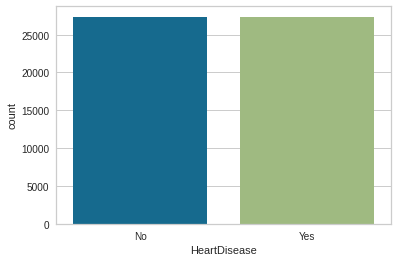

In [ ]:
sns.countplot(data = procdata, x = 'HeartDisease')

One-hot Encoding categorical features. Label encoding will affect the bias of the models.

In [ ]:
procdata = pd.get_dummies(procdata, columns=(["Smoking",'AlcoholDrinking','Stroke', 'DiffWalking','Asthma' ,'KidneyDisease','SkinCancer','PhysicalActivity','Diabetic','GenHealth','Sex','Race'] ))

In [ ]:
procdata.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,AgeCategory,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,...,GenHealth_Poor,GenHealth_Very good,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,No,19.69,0.0,0.0,75-79,8.0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
1,No,25.75,0.0,0.0,70-74,8.0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,No,25.84,0.0,1.0,60-64,7.0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
3,No,30.11,0.0,0.0,55-59,7.0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,No,21.02,3.0,2.0,75-79,9.0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


Replacing the age groups with the average age of that group.

In [ ]:
replace_categs = {"AgeCategory":{"18-24": 21, "25-29": 27, "30-34": 32,"35-39":37, "40-44": 42,"45-49": 47, "50-54": 52,  "55-59": 57,"60-64": 62, "65-69": 67,"70-74":72, "75-79": 77, "80 or older": 85}}
procdata = procdata.replace(replace_categs)
procdata.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,AgeCategory,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,...,GenHealth_Poor,GenHealth_Very good,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,No,19.69,0.0,0.0,77,8.0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
1,No,25.75,0.0,0.0,72,8.0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,No,25.84,0.0,1.0,62,7.0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
3,No,30.11,0.0,0.0,57,7.0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,No,21.02,3.0,2.0,77,9.0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
procdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54746 entries, 0 to 54745
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   HeartDisease                         54746 non-null  object 
 1   BMI                                  54746 non-null  float64
 2   PhysicalHealth                       54746 non-null  float64
 3   MentalHealth                         54746 non-null  float64
 4   AgeCategory                          54746 non-null  int64  
 5   SleepTime                            54746 non-null  float64
 6   Smoking_No                           54746 non-null  uint8  
 7   Smoking_Yes                          54746 non-null  uint8  
 8   AlcoholDrinking_No                   54746 non-null  uint8  
 9   AlcoholDrinking_Yes                  54746 non-null  uint8  
 10  Stroke_No                            54746 non-null  uint8  
 11  Stroke_Yes                  

## Plotting

Below another copy of the processed dataset is made with One-Hot encoding the output for making plots.

In [ ]:
procdata_corr = pd.get_dummies(procdata, columns=(['HeartDisease']))

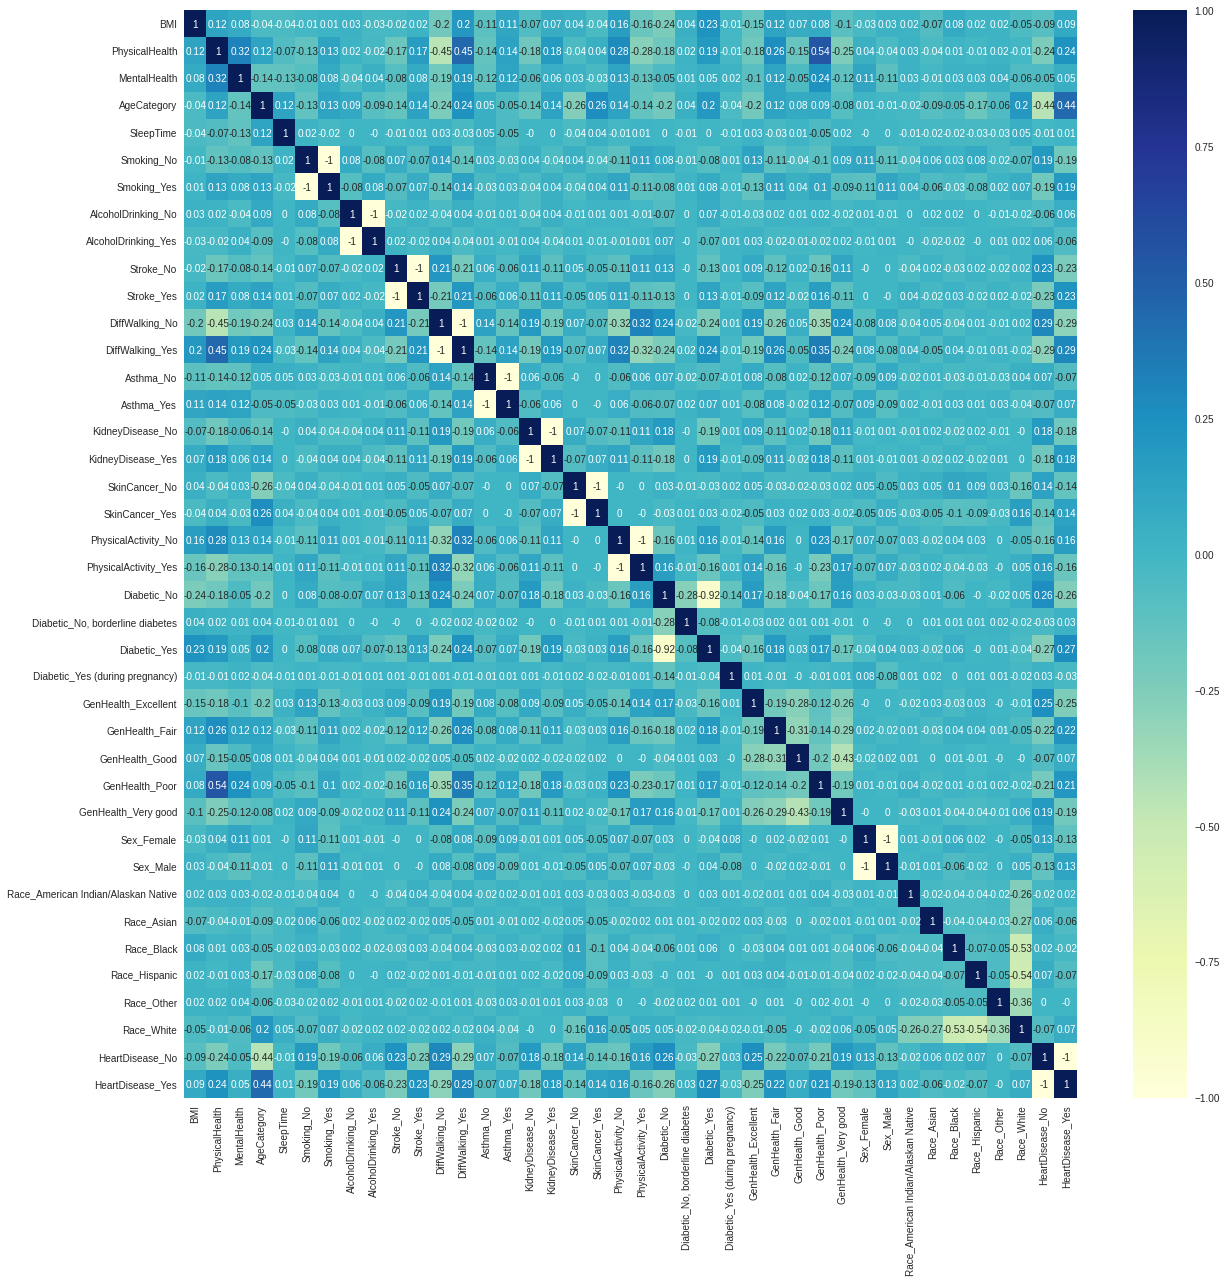

In [ ]:
correlation_matrix = procdata_corr.corr().round(2)
plt.figure(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True,cmap="YlGnBu")

As shown above, Heart disease is highly corellated with age, smoking, diabetic people and even sex.

In [ ]:
fig = px.pie( data_frame = procdata_corr, values= 'HeartDisease_Yes', names= 'AgeCategory', title='')
fig.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig.show()

People of older age are more prone to heart disease than younger people.

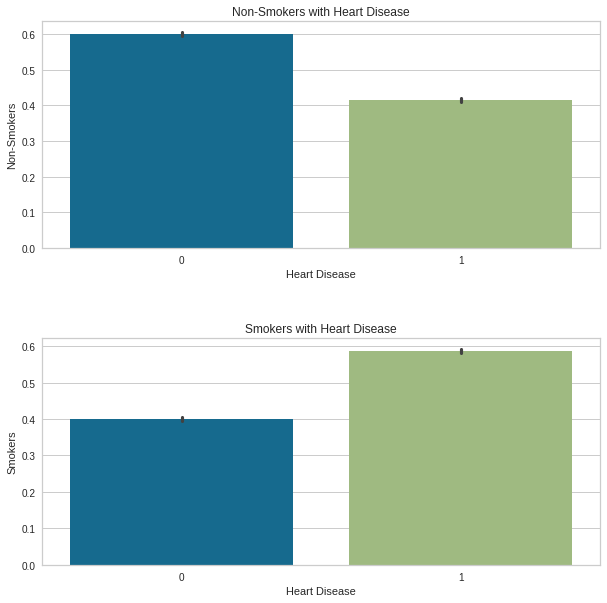

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Smoking_No', ax = ax1)
plt.xlabel('Heart Disease')
plt.ylabel('Non-Smokers')
plt.title('Non-Smokers with Heart Disease')

ax2 = fig.add_subplot(2,1,2)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Smoking_Yes', ax = ax2)
plt.xlabel('Heart Disease')
plt.ylabel('Smokers')
plt.title('Smokers with Heart Disease')
plt.subplots_adjust(hspace = 0.4)

In [ ]:
fig = px.pie( data_frame = procdata_corr, values= 'HeartDisease_No', names= 'Smoking_No',color_discrete_sequence=px.colors.sequential.RdBu, title='No Heart Disease and Smoking')
fig.update_traces(textposition='inside')
fig.show()

fig = px.pie(data_frame = procdata_corr, values = 'HeartDisease_Yes', names = 'Smoking_No', color_discrete_sequence=px.colors.sequential.RdBu, title = 'Yes Heart Disease and Smoking')
fig.update_traces(textposition='inside')
fig.show()

First pie shows that 60% of the people who don't smoke don't have heart disease.

The second pie shows that 58.6% of people who smoke have heart disease.

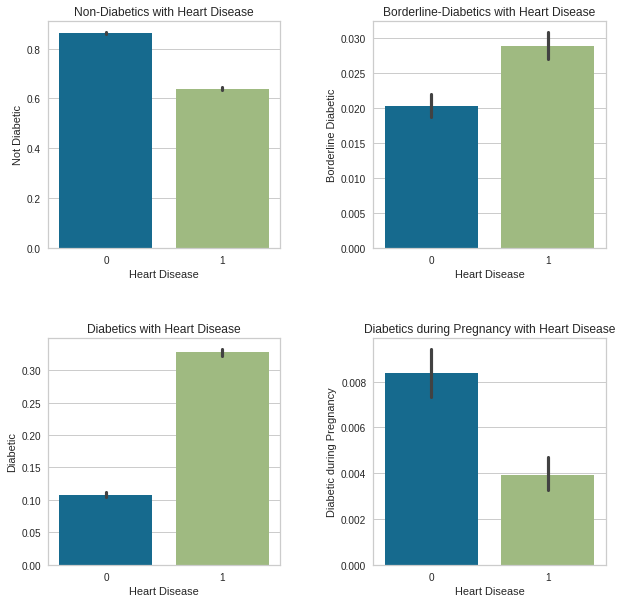

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Diabetic_No', ax = ax1)
plt.xlabel('Heart Disease')
plt.ylabel('Not Diabetic')
plt.title('Non-Diabetics with Heart Disease')

ax2 = fig.add_subplot(2,2,2)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Diabetic_No, borderline diabetes', ax = ax2)
plt.xlabel('Heart Disease')
plt.ylabel('Borderline Diabetic')
plt.title('Borderline-Diabetics with Heart Disease')

ax3 = fig.add_subplot(2,2,3)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Diabetic_Yes', ax = ax3)
plt.xlabel('Heart Disease')
plt.ylabel('Diabetic')
plt.title('Diabetics with Heart Disease')

ax4 = fig.add_subplot(2,2,4)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Diabetic_Yes (during pregnancy)', ax = ax4)
plt.xlabel('Heart Disease')
plt.ylabel('Diabetic during Pregnancy')
plt.title('Diabetics during Pregnancy with Heart Disease')

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

More Borderline diabetics and diabetics have heart disease than people who are non-diabetics.

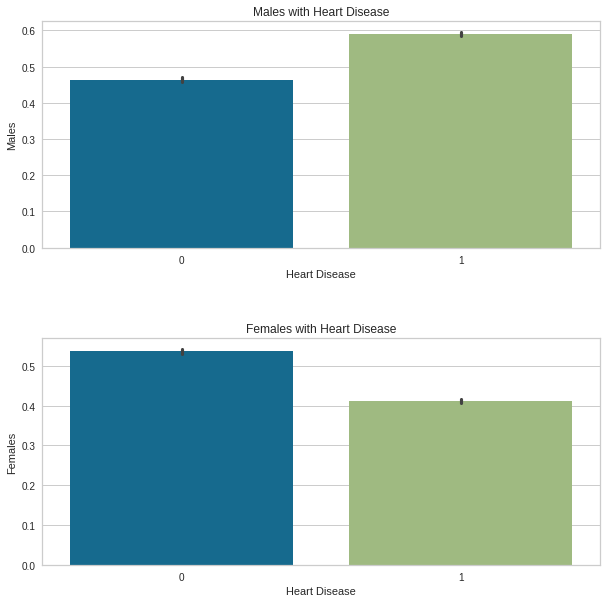

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Sex_Male', ax = ax1)
plt.xlabel('Heart Disease')
plt.ylabel('Males')
plt.title('Males with Heart Disease')

ax2 = fig.add_subplot(2,1,2)
sns.barplot(data = procdata_corr, x = 'HeartDisease_Yes', y = 'Sex_Female', ax = ax2)
plt.xlabel('Heart Disease')
plt.ylabel('Females')
plt.title('Females with Heart Disease')
plt.subplots_adjust(hspace = 0.4)

Males are more prone to heart disease than females, as shown by the plots above.

## Normalizing Dataset

Normalizing the features that their values aren't between 0 and 1.

In [ ]:
norm_scaler = MinMaxScaler()
procdata[['BMI']] = norm_scaler.fit_transform(procdata[['BMI']])
procdata[['PhysicalHealth']] = norm_scaler.fit_transform(procdata[['PhysicalHealth']])
procdata[['MentalHealth']] = norm_scaler.fit_transform(procdata[['MentalHealth']])
procdata[['AgeCategory']] = norm_scaler.fit_transform(procdata[['AgeCategory']])
procdata[['SleepTime']] = norm_scaler.fit_transform(procdata[['SleepTime']])

In [ ]:
procdata.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,AgeCategory,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,...,GenHealth_Poor,GenHealth_Very good,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,No,0.099947,0.0,0.000000,0.875000,0.304348,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
1,No,0.180919,0.0,0.000000,0.796875,0.304348,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,No,0.182122,0.0,0.033333,0.640625,0.260870,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
3,No,0.239177,0.0,0.000000,0.562500,0.260870,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,No,0.117718,0.1,0.066667,0.875000,0.347826,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


## Splitting data 

Splitting data into train, test and validation set.

In [ ]:
procdata.columns

Index(['HeartDisease', 'BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',
       'SleepTime', 'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'Stroke_No', 'Stroke_Yes', 'DiffWalking_No',
       'DiffWalking_Yes', 'Asthma_No', 'Asthma_Yes', 'KidneyDisease_No',
       'KidneyDisease_Yes', 'SkinCancer_No', 'SkinCancer_Yes',
       'PhysicalActivity_No', 'PhysicalActivity_Yes', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White'],
      dtype='object')

In [ ]:
X = procdata [['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory', 'SleepTime',
        'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'Stroke_No', 'Stroke_Yes',
       'DiffWalking_No', 'DiffWalking_Yes', 'Asthma_No', 'Asthma_Yes', 'KidneyDisease_No', 'KidneyDisease_Yes', 'SkinCancer_No',
       'SkinCancer_Yes', 'PhysicalActivity_No', 'PhysicalActivity_Yes', 'Diabetic_No', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good', 'Sex_Female', 'Sex_Male', 'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White']]
y = procdata [['HeartDisease']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print('Loaded: train size:', len(X_train), ', test size:',len(X_test))

Loaded: train size: 43796 , test size: 10950


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1)
print('Loaded: new train size:', len(X_train), ', validation size:',len(X_val))

Loaded: new train size: 39416 , validation size: 4380


## Knn

I've built a loop to calculate which number of neighbors(from 1 to 50) is best to use, based on the accuracy they achieve.

In [ ]:
max = 0
ii = 1
accuracy = []
kn = []
for n_neighbors in range(1,51):
  knnClass = KNeighborsClassifier(n_neighbors)
  knnClass.fit(X_train, np.ravel(y_train))
  y_pred = knnClass.predict(X_val) 

  a = accuracy_score(y_val, y_pred)
  b = precision_score(y_val, y_pred,average = 'weighted')
  c = recall_score(y_val, y_pred,average = 'weighted')
  d = f1_score(y_val, y_pred,average = 'weighted')

  print("Accuracy Score for k=:", n_neighbors, 'is', a)
  print("Precision Score for k=:", n_neighbors, 'is', b)
  print("Recall Score for k=:", n_neighbors, 'is', c)
  print("F1 Score for k=:", n_neighbors, 'is', d)
  print("=======================================")

  if max == a:
    ii = ii + 1
  if max < a:
    max = a
    k = n_neighbors
  accuracy.append(a)
  kn.append(n_neighbors)
    
print('Best k is:', k, 'with accuracy:', max)

Accuracy Score for k=: 1 is 0.6792237442922374
Precision Score for k=: 1 is 0.6792157422865055
Recall Score for k=: 1 is 0.6792237442922374
F1 Score for k=: 1 is 0.6792180083803698
Accuracy Score for k=: 2 is 0.6659817351598174
Precision Score for k=: 2 is 0.6850871399687046
Recall Score for k=: 2 is 0.6659817351598174
F1 Score for k=: 2 is 0.6580956766478441
Accuracy Score for k=: 3 is 0.7134703196347032
Precision Score for k=: 3 is 0.7135862510743386
Recall Score for k=: 3 is 0.7134703196347032
F1 Score for k=: 3 is 0.713361177677107
Accuracy Score for k=: 4 is 0.7054794520547946
Precision Score for k=: 4 is 0.7105514149551967
Recall Score for k=: 4 is 0.7054794520547946
F1 Score for k=: 4 is 0.7040520936055316
Accuracy Score for k=: 5 is 0.7278538812785388
Precision Score for k=: 5 is 0.7283768821041434
Recall Score for k=: 5 is 0.7278538812785388
F1 Score for k=: 5 is 0.7275856954463645
Accuracy Score for k=: 6 is 0.7289954337899544
Precision Score for k=: 6 is 0.7303967399099202
R

Text(0.5, 1.0, 'Validation Accuracy with different Kneighbors')

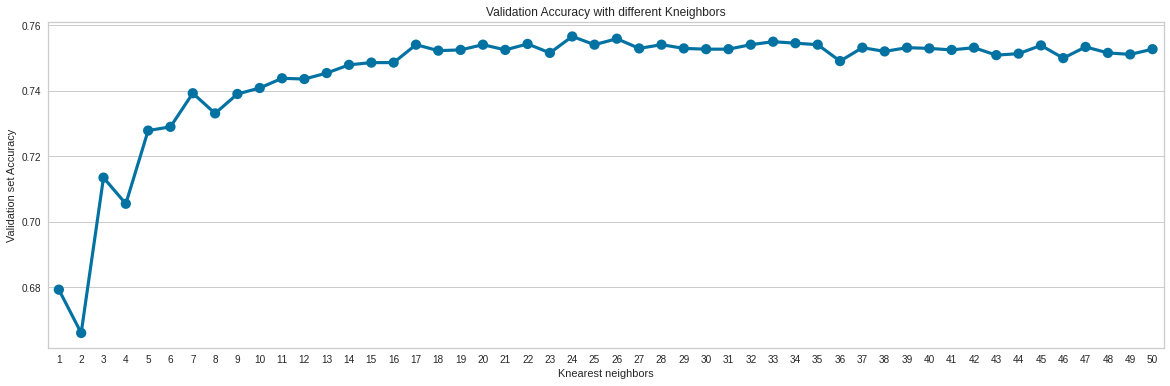

In [ ]:
fig  = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
sns.pointplot(x = kn, y = accuracy, ax = ax)
plt.xlabel('Knearest neighbors')
plt.ylabel('Validation set Accuracy')
plt.title('Validation Accuracy with different Kneighbors')

Best k is: 24 with accuracy: 0.7566210045662101.



In [ ]:
knnClass = KNeighborsClassifier(k)
knnClass.fit(X_train, np.ravel(y_train))
y_pred = knnClass.predict(X_val) 

In [ ]:
target_names = ['HeartDisease_No','HeartDisease_Yes']
print(classification_report(y_val, y_pred, target_names= target_names))

                  precision    recall  f1-score   support

 HeartDisease_No       0.77      0.73      0.75      2169
HeartDisease_Yes       0.75      0.78      0.76      2211

        accuracy                           0.76      4380
       macro avg       0.76      0.76      0.76      4380
    weighted avg       0.76      0.76      0.76      4380



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



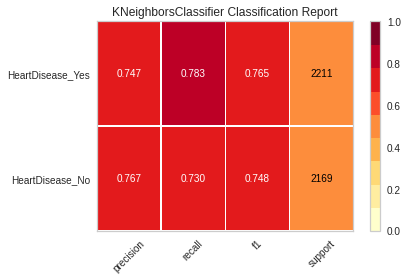

In [ ]:
visualizer = ClassificationReport(knnClass, classes=['HeartDisease_No','HeartDisease_Yes'], support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

Further down, a confusion matrix is implemented for train, test and validation set. 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



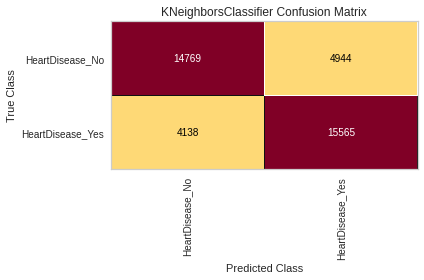

In [ ]:
cm = ConfusionMatrix(knnClass, classes=['HeartDisease_No','HeartDisease_Yes'])
cm.fit(X_train, np.ravel(y_train))
cm.score(X_train, np.ravel(y_train))
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



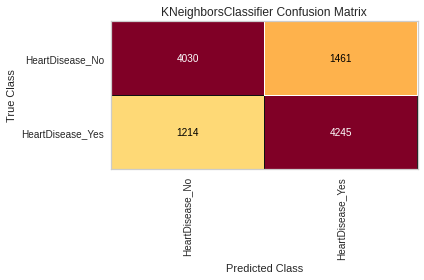

In [ ]:
cm = ConfusionMatrix(knnClass, classes=['HeartDisease_No','HeartDisease_Yes'])
cm.fit(X_train, np.ravel(y_train))
cm.score(X_test, np.ravel(y_test))
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



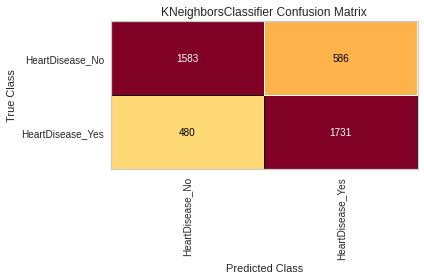

In [ ]:
cm = ConfusionMatrix(knnClass, classes=['HeartDisease_No','HeartDisease_Yes'])
cm.fit(X_train, np.ravel(y_train))
cm.score(X_val, np.ravel(y_val))
cm.show()

## Random Forest

A Random Forest Classifier model is being implemented for classifying if a person has heart disease or not. 

A random search grid is implemented below for finding the optimal parameters for the random forest classifier.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [ 200, 400, 500, 600, 700, 800, 900, 1000, 1400, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60 ,70, 80, 85, 90, 95, 100]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
randfor_class = RandomForestClassifier()

# search across 100 different combinations, and use all available cores
cv= KFold(n_splits=5, shuffle=True, random_state=1)
rf = RandomizedSearchCV(estimator = randfor_class, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, n_jobs = -1)# Fit the random search model
rf.fit(X_train, y_train)

print(rf.best_params_)

{'n_estimators': [200, 400, 500, 600, 700, 800, 900, 1000, 1400, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 85, 90, 95, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 500, 600,
                                                         700, 800, 900, 1000,
                                                         1400, 2000]},
                   verbose=2)

In [ ]:
print(rf.best_params_)

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 85, 'bootstrap': True}


In [ ]:
print(rf.score(X_test, y_test))

0.7717808219178082


In [ ]:
print(rf.score(X_val, y_val))

0.7662100456621005


The best parameters of the search grid are used

In [ ]:
randfor = RandomForestClassifier( n_estimators= 2000, criterion='entropy',max_features = 'log2', min_samples_split = 10, min_samples_leaf = 4, bootstrap=True, n_jobs= -1,  random_state=1, max_depth=85 )
randfor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(criterion='entropy', max_depth=85, max_features='log2',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=1)

In [ ]:
print('Accuracy of test set is: ', randfor.score(X_train,y_train))
print('Accuracy of test set is: ',randfor.score(X_test,y_test))
print('Accuracy of validation set is: ',randfor.score(X_val,y_val))

Accuracy of test set is:  0.8128678709153643
Accuracy of test set is:  0.7690410958904109
Accuracy of validation set is:  0.758675799086758


In [ ]:
y_pred = randfor.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



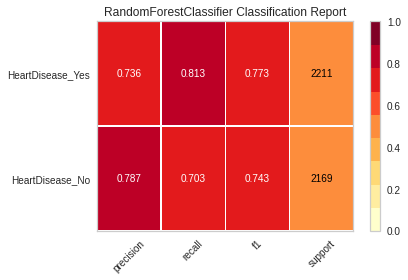

In [ ]:
visualizer = ClassificationReport(randfor, classes=['HeartDisease_No','HeartDisease_Yes'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

Below, three Confusion Matrix graphs are implemented to get information for True Positive(TP), False Positive(FP), True Negative(TN) and False Negative(FN) values in the training, test and validation set.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



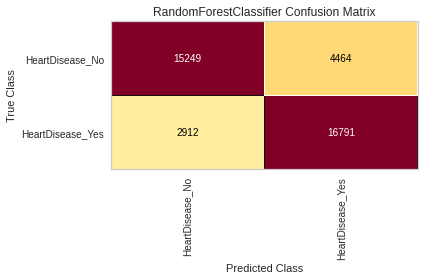

In [ ]:
cm = ConfusionMatrix(randfor, classes=['HeartDisease_No','HeartDisease_Yes'])

cm.fit(X_train, y_train)

cm.score(X_train, y_train)
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



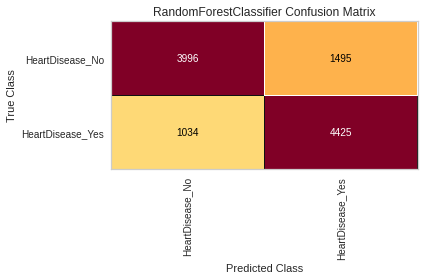

In [ ]:
#ConfusionMatrix
cm = ConfusionMatrix(randfor, classes=['HeartDisease_No','HeartDisease_Yes'])

cm.fit(X_train, y_train)

cm.score(X_test, y_test)
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



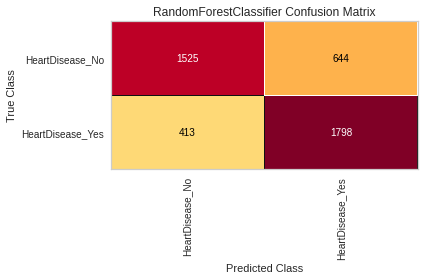

In [ ]:
cm = ConfusionMatrix(randfor, classes=['HeartDisease_No','HeartDisease_Yes'])
cm.fit(X_train, y_train)
cm.score(X_val, y_val)
cm.show()